***
# **Small-MOCCA: Dataset exploration**

***
Exploration of a subset of the MOCCA Survey Dataset I. Creation of a regressión dataset for $M_{\text MMO}$ estimation. 

> **Status:** Load of information available and operating.
***

In [1]:
# Libraries -----------------------------------------------------------------------------------------------------#
import os

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
#----------------------------------------------------------------------------------------------------------------#

In [2]:
# Change to working directory -----------------------------------------------------------------------------------#
os.chdir("../")
#----------------------------------------------------------------------------------------------------------------#

In [3]:
# Custome functions ---------------------------------------------------------------------------------------------#
from src.utils.directory         import list_all_directories, load_mocca_survey_imbh_history
from src.utils.phyfactors        import relaxation_time, collision_time, core_collapse_time
from src.utils.phyfactors        import critical_mass, rho_at_rh
from src.utils.vizualize         import corr_plot, boxplot_analysis, plot_full_correlogram
from src.processing.format       import target_preparation, time_preparation
from src.processing.moccasurvey  import mocca_survey_dataset
#----------------------------------------------------------------------------------------------------------------#

## **$\bullet$ Simulation files: Exploration**

In [4]:
# Load name files and directories -------------------------------------------------------------------------------#
sim_files_path = "./rawdata/moccasurvey/simulations/"
simulations    = list_all_directories(sim_files_path)

# Verbose
print(f"Total MOCCA Models available for analysis: {len(simulations)}")
#----------------------------------------------------------------------------------------------------------------#

Total MOCCA Models available for analysis: 455


In [5]:
# Load simulation info ------------------------------------------------------------------------------------------#
imbh_history, system = load_mocca_survey_imbh_history(file_path = f"{simulations[27]}/",
                                                    init_conds_sim  = True,
                                                    col_description = True,
                                                    stellar_map     = True,
                                                    init_conds_evo  = True)

# Getting imbh history df, initial_conditions, column definitions, and stellar type mappig
imbh_df           = imbh_history[0]
imbh_init_conds   = imbh_history[1]
imbh_col_dict     = imbh_history[2]
imbh_stellar_dict = imbh_history[3]

# Retrive temporal evolution df of initial conditions and their column descriptions
system_df       = system[0]
system_col_dict = system[1]

#----------------------------------------------------------------------------------------------------------------#

In [6]:
# Columns of interest and details of the system df ....----------------------------------------------------------#
int_cols = ["17", "3", "23", "46", "44", "28", "2", "11"]

print(110*"_")
print("Columns of interest in the system dataframe")
for n_col in int_cols:
    print(110*"_")
    print(f"Column number      : {n_col}")
    print(f"Column name        : {system_col_dict[n_col]['column']}")
    print(f"Column description : {system_col_dict[n_col]['description']}")

print(110*"_")
print("Details of interest in the system dataframe")
print(f"Number of rows         : {len(system_df)}")
print(f"Maximun evolution time : {system_df['tphys'].max()}")
print(110*"_")
#----------------------------------------------------------------------------------------------------------------#

______________________________________________________________________________________________________________
Columns of interest in the system dataframe
______________________________________________________________________________________________________________
Column number      : 17
Column name        : r_h
Column description : actual half-mas radius in pc
______________________________________________________________________________________________________________
Column number      : 3
Column name        : smt
Column description : total mass in Msun
______________________________________________________________________________________________________________
Column number      : 23
Column name        : vc
Column description : central velocity dispersion in km/s (mass weighted)
______________________________________________________________________________________________________________
Column number      : 46
Column name        : nt
Column description : actual number of objects

In [7]:
# Columns of interest and details of the history df ....---------------------------------------------------------#
int_cols = ["4", "10"]

print(110*"_")
print("Columns of interest in the imbh history dataframe")
for n_col in int_cols:
    print(110*"_")
    print(f"Column number      : {n_col}")
    print(f"Column name        : {imbh_col_dict[n_col]['column']}")
    print(f"Column description : {imbh_col_dict[n_col]['description']}")

print(110*"_")
print("Details of interest in the imbh history dataframe")
print(f"Number of rows         : {len(imbh_df)}")
print(f"Maximun evolution time : {imbh_df['time[Myr]'].max()}")
print(110*"_")
#----------------------------------------------------------------------------------------------------------------#

______________________________________________________________________________________________________________
Columns of interest in the imbh history dataframe
______________________________________________________________________________________________________________
Column number      : 4
Column name        : time
Column description : Time of the event in Myr
______________________________________________________________________________________________________________
Column number      : 10
Column name        : massNew
Column description : Mass of the primary after the event [Msun]
______________________________________________________________________________________________________________
Details of interest in the imbh history dataframe
Number of rows         : 15350
Maximun evolution time : 14999.267
______________________________________________________________________________________________________________


In [8]:
# Extract the example of initial conditions ---------------------------------------------------------------------#
rh      = system_df["r_h"][0]
v_disp  = system_df["vc"][0]
m_tot   = system_df["smt"][0]
n       = system_df["nt"][0]
m_mean  = system_df["atot"][0]
m_max   = system_df["smsm"][0]
cr      = system_df["rc"][0]
tau     = imbh_df["time[Myr]"].max() - imbh_df["time[Myr]"].min()

print(100*"_")
print("Initial conditions for the selected simulation:")
print(100*"_")
print(f"  Half-mass radius (r_h)       : {rh:.3f} pc")
print(f"  Velocity dispersion (v_disp) : {v_disp:.3f} km/s")
print(f"  Total mass (m_tot)           : {m_tot:.3e} Msun")
print(f"  Number of stars (n)          : {n}")
print(f"  Mean stellar mass (m_mean)   : {m_mean:.3f} Msun")
print(f"  Maximum stellar mass (m_max) : {m_max:.3f} Msun")
print(f"  Core radius (rc)             : {cr:.3f} pc")
print(f"  Cluster evolution time (tau) : {tau:.3f} Myr")
print(100*"_")
#----------------------------------------------------------------------------------------------------------------#

____________________________________________________________________________________________________
Initial conditions for the selected simulation:
____________________________________________________________________________________________________
  Half-mass radius (r_h)       : 0.599 pc
  Velocity dispersion (v_disp) : 31.963 km/s
  Total mass (m_tot)           : 4.242e+05 Msun
  Number of stars (n)          : 700000
  Mean stellar mass (m_mean)   : 0.606 Msun
  Maximum stellar mass (m_max) : 99.719 Msun
  Core radius (rc)             : 0.220 pc
  Cluster evolution time (tau) : 14999.267 Myr
____________________________________________________________________________________________________


In [9]:
# Compute an example of the relevant physical quantities --------------------------------------------------------#
t_relax  = relaxation_time(n_stars=n, hm_radius=rh, v_disp=v_disp, mtot=None)
rho_half = rho_at_rh(n_stars=n, hm_radius=rh)
t_coll   = collision_time(hm_radius=rh, n_stars=n, mass_per_star=m_mean, v_disp=v_disp, stellar_radius=1.0)
t_cc     = core_collapse_time(m_mean=m_mean, m_max=m_max, n_stars=n, hm_radius=rh, v_disp=v_disp, mtot=None)  
M_crit   = critical_mass(hm_radius=rh, mass_per_star=m_mean, cluster_age=tau, v_disp=v_disp, stellar_radius=1.0)

print(100*"_")
print("Physical timescales and quantities:")
print(100*"_")
print(f"  Relaxation time             (t_relax) : {t_relax:.3f} ")
print(f"  Collision time              (t_coll)) : {t_coll:.3f} ")
print(f"  Core collapse time          (t_cc)    : {t_cc:.3f} ")
print(f"  Density at half-mass radius (rho_rh)  : {rho_half:.3f} ")
print(f"  Critical mass               (M_crit)  : {M_crit:3e} ")
print(100*"_")
#----------------------------------------------------------------------------------------------------------------#

____________________________________________________________________________________________________
Physical timescales and quantities:
____________________________________________________________________________________________________
  Relaxation time             (t_relax) : 95.356 Myr 
  Collision time              (t_coll)) : 94932.443 Myr 
  Core collapse time          (t_cc)    : 1.912 Myr 
  Density at half-mass radius (rho_rh)  : 388159.526 1 / pc3 
  Critical mass               (M_crit)  : 6.354095e+05 solMass 
____________________________________________________________________________________________________


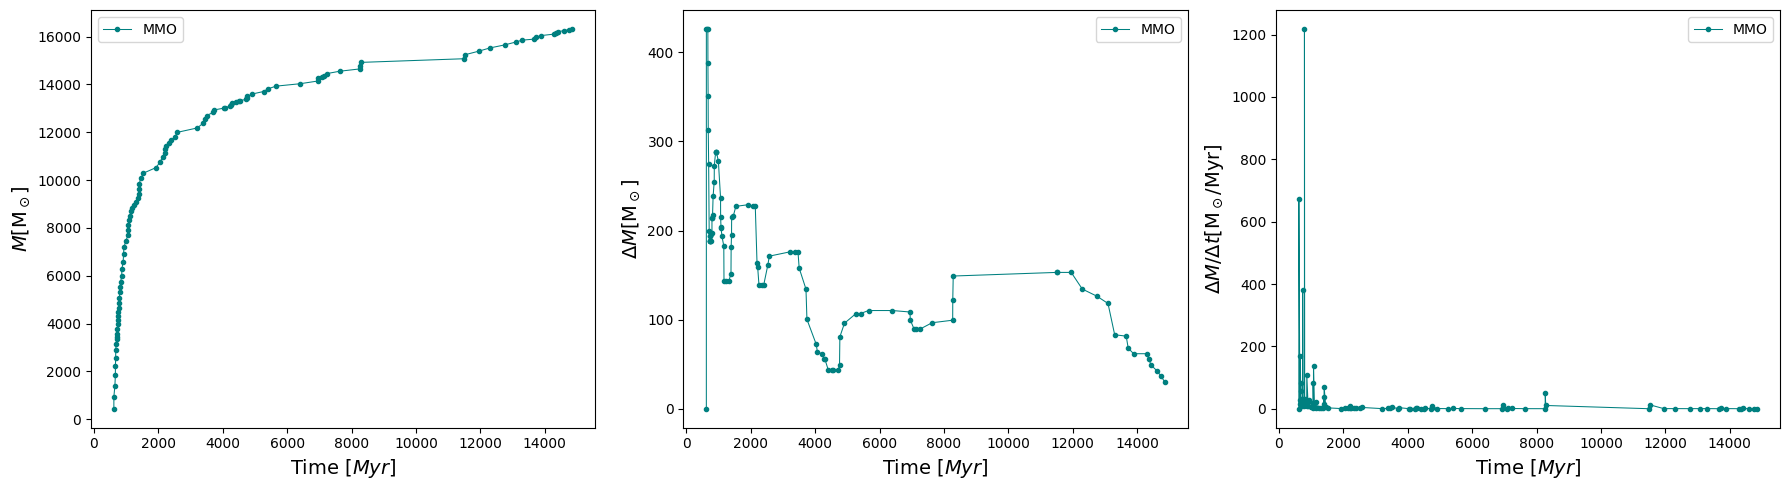

In [14]:
example_df = imbh_df.drop_duplicates(subset="time[Myr]")

# Get random indices for 80% of the data
#n_samples      = int(len(example_df) * 0.8)
random_indices = example_df.sample(n=100, random_state=42).index

# Select those rows and sort by time
sample_df = example_df.loc[random_indices].sort_values('time[Myr]')

fig, ax  = plt.subplots(1, 3, figsize=(18, 5))

# retrieve temporal values
m_evol    = target_preparation(mass_evolution  = sample_df["massNew[Msun](10)"],
                                time_evolution = sample_df["time[Myr]"], 
                                norm_factor    = None,
                                target_type    = "point_mass",
                                log10_scale    = False)

time_evol = time_preparation(time_evolution = sample_df["time[Myr]"],
                             norm_factor    = None)

# First subplot: IMBH mass
ax[0].plot(time_evol, m_evol, lw=0.75, label='MMO', color="teal", marker=".") 
ax[0].set_ylabel(r'$M[\rm M_\odot]$', size=14)
ax[0].set_xlabel('Time $[Myr]$', size=14)
ax[0].legend()

# retrieve temporal values
dm_evol   = target_preparation(mass_evolution  = sample_df["massNew[Msun](10)"],
                                time_evolution = sample_df["time[Myr]"], 
                                norm_factor    = None,
                                target_type    = "delta_mass",
                                log10_scale    = False)
time_evol = time_preparation(time_evolution = sample_df["time[Myr]"],
                             norm_factor    = None)


# Second subplot: IMBH mass change
ax[1].plot(time_evol, dm_evol, lw=0.75, label='MMO', color="teal", marker=".") 
ax[1].set_ylabel(r'$\Delta M[\rm M_\odot]$', size=14)
ax[1].set_xlabel('Time $[Myr]$', size=14)
#ax[1].set_yscale("log")
ax[1].legend()

# retrieve temporal values
dmdt_evol = target_preparation(mass_evolution  = sample_df["massNew[Msun](10)"],
                                time_evolution = sample_df["time[Myr]"], 
                                norm_factor    = None,
                                target_type    = "mass_rate",
                                log10_scale    = False)
time_evol = time_preparation(time_evolution = sample_df["time[Myr]"],
                             norm_factor    = None)


# Third subplot: IMBH mass rate
ax[2].plot(time_evol, dmdt_evol, lw=0.75, label='MMO', color="teal", marker=".") 
ax[2].set_ylabel(r'$\Delta M /\Delta t[\rm M_\odot/Myr]$', size=14)
ax[2].set_xlabel('Time $[Myr]$', size=14)
#ax[2].set_yscale("log")
ax[2].legend()

plt.tight_layout()
#plt.savefig("sim_preprocess.jpg")
plt.show()

## **$\bullet$ Dataset for ML estimation**

In [4]:
train_df = pd.read_csv("./datasets/moccasurvey/pm_exp/0_fold/train.csv")
val_df   = pd.read_csv("./datasets/moccasurvey/pm_exp/0_fold/val.csv")
test_df  = pd.read_csv("./datasets/moccasurvey/pm_exp/test.csv")

In [7]:
# Plot features for point mass experiment

# Target
train_df["log(M_MMO)"]      = np.log10(train_df["M_MMO"].to_numpy() + 1)

# Feeatures
train_df["t/t_coll"]        = train_df["t"] / train_df["t_coll"] 
train_df["log(rho(R_h))"]   = np.log10(train_df["rho(R_h)"].to_numpy() + 1)
train_df["M_tot/M_crit"]    = train_df["M_tot"] / train_df["M_crit"] 
train_df["R_h/R_core"]      = train_df["R_h"] / train_df["R_core"] 
train_df["log(R_h/R_core)"] = np.log10(train_df["R_h/R_core"].to_numpy() + 1)

# Target
val_df["log(M_MMO)"]    = np.log10(val_df["M_MMO"].to_numpy() + 1)

# Feeatures
val_df["t/t_coll"]        = val_df["t"] / val_df["t_coll"] 
val_df["log(rho(R_h))"]   = np.log10(val_df["rho(R_h)"].to_numpy() + 1)
val_df["M_tot/M_crit"]    = val_df["M_tot"] / val_df["M_crit"] 
val_df["R_h/R_core"]      = val_df["R_h"] / val_df["R_core"] 
val_df["log(R_h/R_core)"] = np.log10(val_df["R_h/R_core"].to_numpy() + 1)


# Target
test_df["log(M_MMO)"]    = np.log10(test_df["M_MMO"].to_numpy() + 1)

# Feeatures
test_df["t/t_coll"]        = test_df["t"] / test_df["t_coll"] 
test_df["log(rho(R_h))"]   = np.log10(test_df["rho(R_h)"].to_numpy() + 1)
test_df["M_tot/M_crit"]    = test_df["M_tot"] / test_df["M_crit"] 
test_df["R_h/R_core"]      = test_df["R_h"] / test_df["R_core"] 
test_df["log(R_h/R_core)"] = np.log10(test_df["R_h/R_core"].to_numpy() + 1)

feature        = ["t/t_coll", "M_tot/M_crit", "log(rho(R_h))", "R_h/R_core", "log(M_MMO)"]
features_names = [r"$t/t_{\rm coll}$", 
                    r"$M_{\rm tot}/M_{\rm crit}$", 
                    r"$\log(\rho(R_{h}))$",
                    r"$R_{h}/R_{\rm core}$", 
                    r"$\log(M_{\rm MMO})$"]

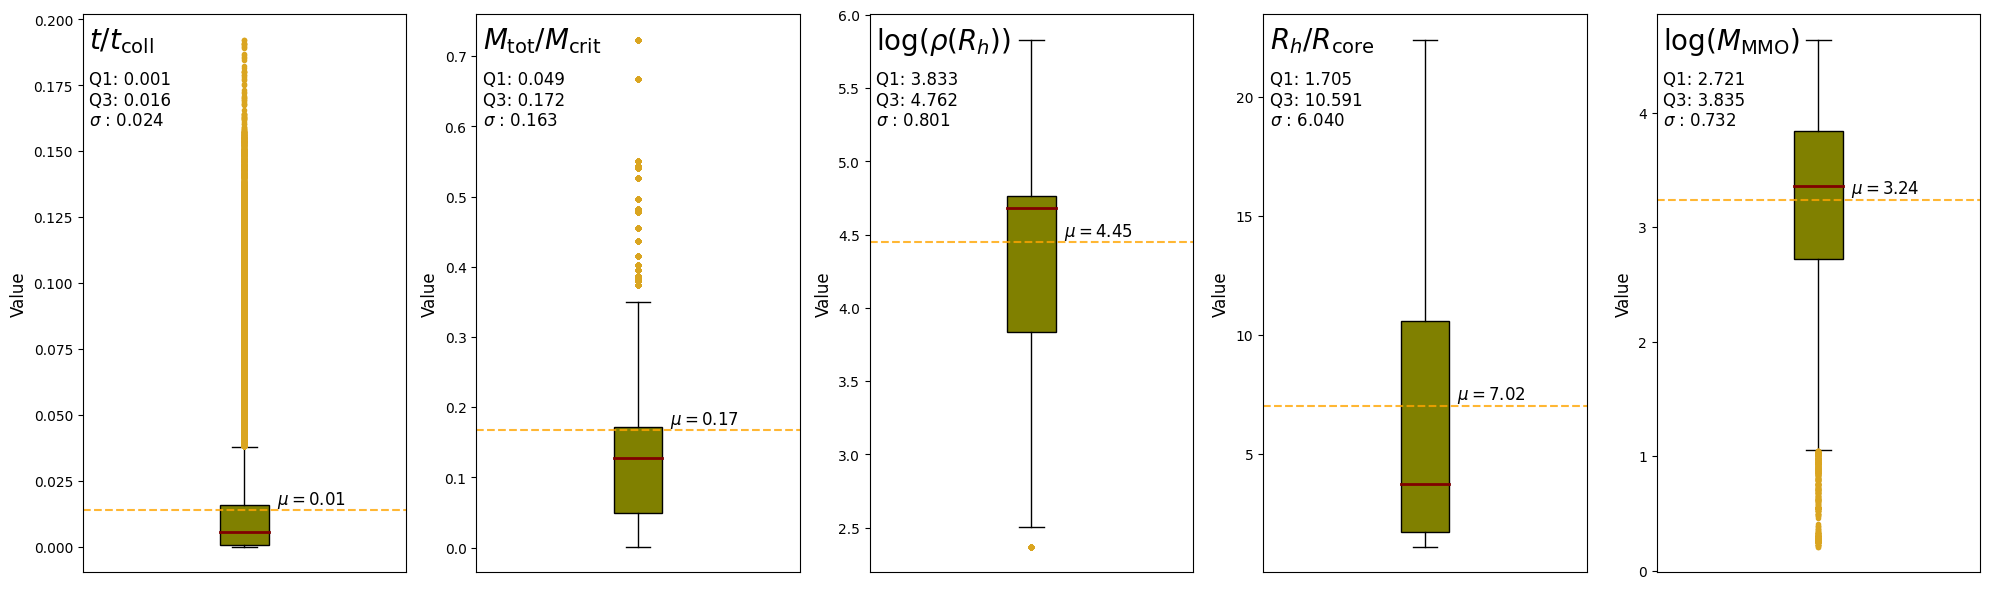

In [13]:
boxplot_analysis(features= train_df[feature], feature_names= features_names,
                 path_save= "./figures/moccasurvey/",
                 name_file= "pm_exp_1",
                 dataset_name= "moccasurvey",
                 figsize= (20,6))

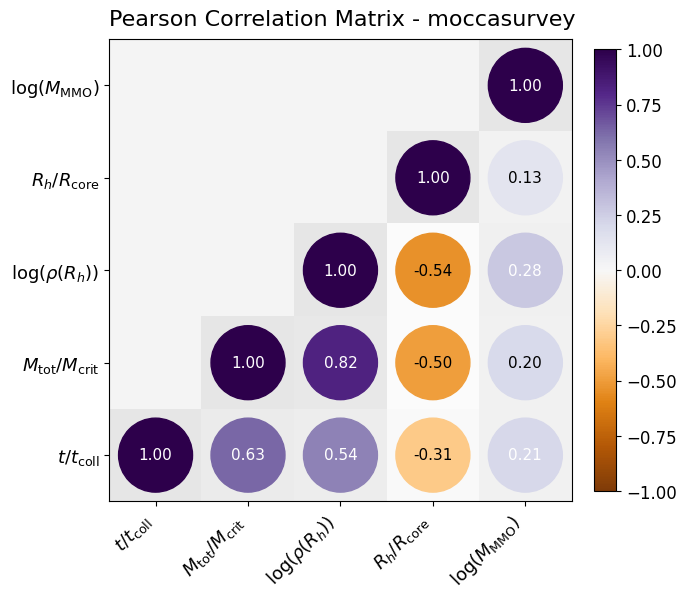

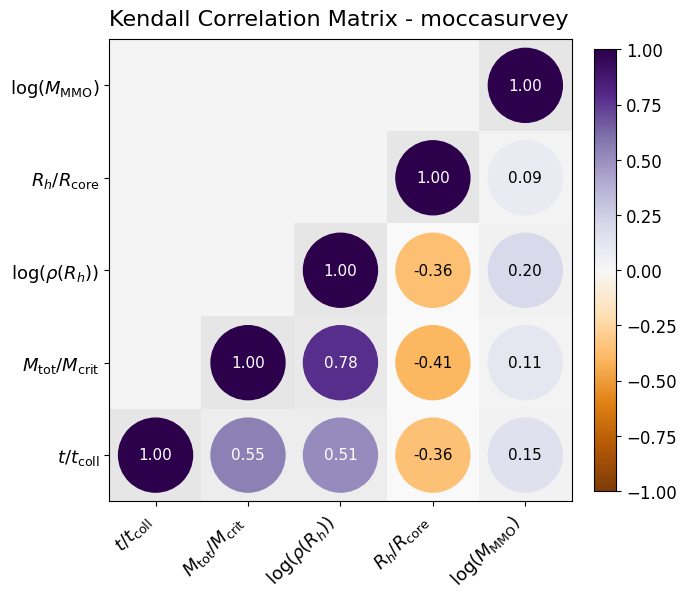

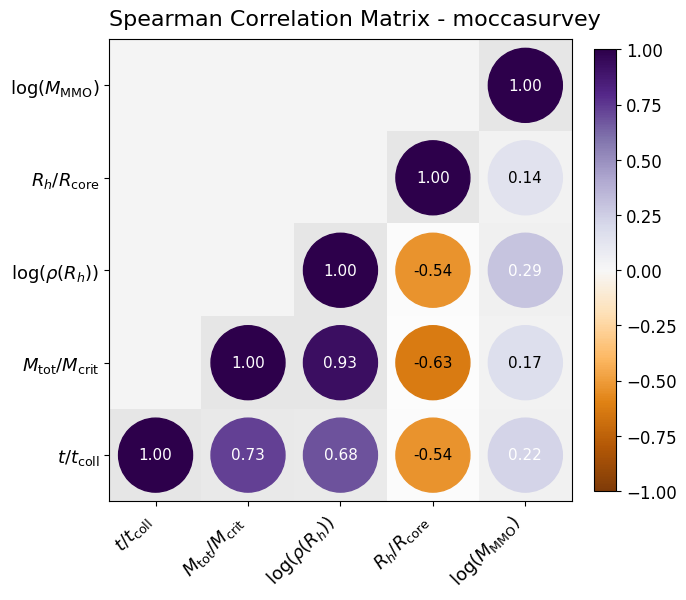

In [14]:
plot_full_correlogram(df= train_df[feature], method= "pearson", path_save="./figures/moccasurvey/",
                    name_file= "pm_exp_1",
                    dataset_name= "moccasurvey",
                    labels= features_names)

plot_full_correlogram(df= train_df[feature], method= "kendall", path_save="./figures/moccasurvey/",
                    name_file= "pm_exp_1",
                    dataset_name= "moccasurvey",
                    labels= features_names)

plot_full_correlogram(df= train_df[feature], method= "spearman", path_save="./figures/moccasurvey/",
                    name_file= "pm_exp_1",
                    dataset_name= "moccasurvey",
                    labels= features_names)

In [6]:
from src.models.mltrees.regressor import MLTreeRegressor

/home/jsaavedra/.local/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [8]:
# Features
X_train = train_df[feature[:-1]].to_numpy()
X_val   = val_df[feature[:-1]].to_numpy()
X_test  = test_df[feature[:-1]].to_numpy()

# Target
y_train  = train_df["log(M_MMO)"].to_numpy()
y_val    = val_df["log(M_MMO)"].to_numpy()
y_test   = test_df["log(M_MMO)"].to_numpy()


In [15]:
model = MLTreeRegressor(model_type   = "xgboost",
                        verbose       = True)

model.fit(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, early_stopping_rounds=50)

metrics = model.evaluate(X=X_test, y=y_test)

Initializing xgboost model...
Successfully initialized xgboost model
Fitting xgboost model with 120000 samples...
Successfully fitted xgboost model


In [13]:
model.save_model(path="./outputs/mltrees_xgb_point_mass/traines_weights.pkl")

Model saved successfully to: ./outputs/mltrees_xgb_point_mass/traines_weights.pkl


In [16]:
metrics

{'mse': 0.27683797639967195,
 'rmse': 0.5261539474333268,
 'mae': 0.3883766732778583,
 'r2': 0.5849088840868772}

In [17]:
y_pred = model.predict(X=X_test)

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
# Recovering natural units
y_rescaled_test = 10**y_test +1
y_rescaled_pred = 10**y_pred +1

# Evaluation
mse  = mean_squared_error(y_rescaled_test, y_rescaled_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_rescaled_test, y_rescaled_pred)
mape = mean_absolute_percentage_error(y_rescaled_test, y_rescaled_pred)
r2   = r2_score(y_rescaled_test, y_rescaled_pred)

print(f"Test MSE  : {mse:.4f}")
print(f"Test RMSE : {rmse:.4f}")
print(f"Test MAE  : {mae:.4f}")
print(f"Test MAPE : {mape*100:.2f} %")
print(f"Test R2   : {r2:.4f}")

Test MSE  : 16952869.2500
Test RMSE : 4117.3862
Test MAE  : 2264.5854
Test MAPE : 272.31 %
Test R2   : 0.5429


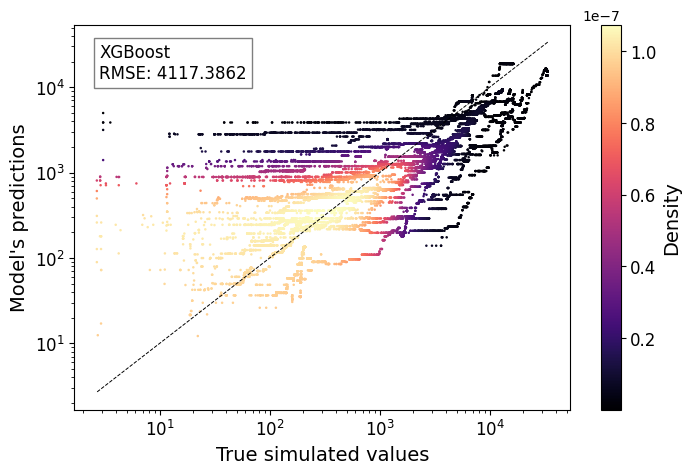

In [20]:
corr_plot(predictions = y_rescaled_pred, 
          true_values = y_rescaled_test, 
          path_save   = "./", 
          name_file   = "proof_of_concepts", 
          model_name  = "XGBoost",
          scale       = "log")


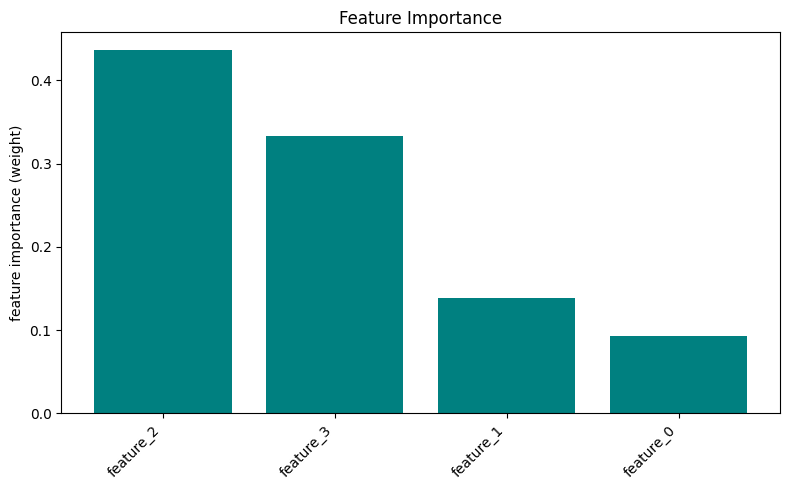

In [25]:
# Get feature importances (e.g., by gain)
importances_dict = model.get_feature_importance()
# Convert to lists and sort by importance descending
features_names   = list(importances_dict.keys())
importances      = list(importances_dict.values())

# Sort indices by importance descending
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.bar(range(len(importances)), [importances[i] for i in indices], align='center', color="teal")
plt.xticks(range(len(importances)), [features_names[i] for i in indices], rotation=45, ha='right')
plt.ylabel('feature importance (weight)')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [26]:
model.training_history

{}